# Import Libralies

In [1]:
import zipfile
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)


# Load & Clean Data

Load raw dataset (CSV inside ZIP)

In [2]:
zip_path = "../data/scbpocseasta001stdsbx.z23.web.core.windows.net"

with zipfile.ZipFile(zip_path, 'r') as z:
    csv_name = [name for name in z.namelist() if name.endswith(".csv")][0]
    print("Reading:", csv_name)

    with z.open(csv_name) as f:
        df = pd.read_csv(f)

print("Loaded dataframe with shape:", df.shape)
df.head()


Reading: fraud_mock.csv
Loaded dataframe with shape: (6362620, 11)


,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
2,1,TRANSFER,181.00,acc1796908,181.0,0.00,acc4938640,0.0,0.0,1,0
3,1,CASH_OUT,181.00,acc4182296,181.0,0.00,acc1221153,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0


Basic Cleaning

In [3]:
# Fix PAYMENT rows: dst_bal should be NaN for merchants
fix_cols = ['dst_bal', 'dst_new_bal']
df.loc[(df['transac_type'] == 'PAYMENT'), fix_cols] = np.nan


# Feature Engineering & Selection

## Feature Engineering

Time-based feature: hour_of_day

In [4]:
# สร้างฟีเจอร์ hour_of_day (0-23)
df['hour_of_day'] = df['time_ind'] % 24

print("Feature 'hour_of_day' created.")
df[['time_ind', 'hour_of_day']].head()

Feature 'hour_of_day' created.


,time_ind,hour_of_day
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


Drop high-cardinality or unused features

In [5]:
unused_cols = [
'src_acc', 'dst_acc', # high cardinality
'src_new_bal', 'dst_new_bal', # multicollinearity
'is_flagged_fraud', # low predictive power
'time_ind' # already transformed to hour_of_day
]
df.drop(columns=unused_cols, inplace=True, errors='ignore')


## Feature Selection

เหตุผลที่เลือก (Selected):
- amount, src_bal, dst_bal: ผล ANOVA (หลังจากเปลี่ยน 0 ให้เป็น NaN) ยืนยันว่าสำคัญ
- transac_type, hour_of_day: ผล Chi-Square ยืนยันว่าสำคัญ

เหตุผลที่ตัดทิ้ง (Rejected):

- src_new_bal, dst_new_bal: ตัดทิ้งเพื่อแก้ปัญหา Multicollinearity (ซ้ำซ้อนกับ src_bal, dst_bal)
- is_flagged_fraud: ตรวจจับ Fraud ไม่ได้เลย
- time_ind: ถูกแทนที่ด้วย hour_of_day แล้ว
- src_acc, dst_acc: มี Cardinality (จำนวนค่าที่ไม่ซ้ำกัน) สูงเกินไป

In [6]:
# กำหนดตัวแปรเป้าหมาย (Target)
target = 'is_fraud'

# กำหนดฟีเจอร์เชิงปริมาณ (Continuous Features)
continuous_features = ['amount', 'src_bal', 'dst_bal']

# กำหนดฟีเจอร์เชิงหมวดหมู่ (Categorical Features)
categorical_features = ['transac_type', 'hour_of_day']

In [7]:
# สร้าง X (Features)
X = df[continuous_features + categorical_features]

# สร้าง y (Target)
y = df[target]

print("--- X (Features) DataFrame ---")
print(f"Shape: {X.shape}")
print(X.info())
X.head()

print("\n--- y (Target) Series ---")
print(f"Shape: {y.shape}")
print(y.value_counts(normalize=True))
y.head()

--- X (Features) DataFrame ---
Shape: (6362620, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   amount        float64
 1   src_bal       float64
 2   dst_bal       float64
 3   transac_type  object 
 4   hour_of_day   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 242.7+ MB
None

--- y (Target) Series ---
Shape: (6362620,)
is_fraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


0    0
1    0
2    1
3    1
4    0
Name: is_fraud, dtype: int64

# Time-based Train/Val/Test Split

In [8]:
# 80/10/10
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]


# Preprocessing & Train Model

In [ ]:
# Pipeline for Continuous Features
cont_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),             
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')), 
    ('scaler', StandardScaler())                              
])

# Pipeline for Categorical Features
cate_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both using ColumnTransformer
col_transformer = ColumnTransformer([
    ('cont', cont_pipeline, continuous_features),
    ('cate', cate_pipeline, categorical_features)
])


In [10]:
print("Preprocessing X_train (Fitting)...")
X_train_trans = col_transformer.fit_transform(X_train)

print("Preprocessing X_val (Transforming)...")
X_val_trans = col_transformer.transform(X_val)

print("Preprocessing X_test (Transforming)...")
X_test_trans = col_transformer.transform(X_test)

print("All data sets are preprocessed and ready for training.")



Preprocessing X_train (Fitting)...
Preprocessing X_val (Transforming)...
Preprocessing X_test (Transforming)...
All data sets are preprocessed and ready for training.


Using scale_pos_weight = 1284.70
Training model...
[0]	validation_0-aucpr:0.18149	validation_1-aucpr:0.21422
[1]	validation_0-aucpr:0.36719	validation_1-aucpr:0.46808
[2]	validation_0-aucpr:0.46743	validation_1-aucpr:0.54165
[3]	validation_0-aucpr:0.46424	validation_1-aucpr:0.52365
[4]	validation_0-aucpr:0.46669	validation_1-aucpr:0.52549
[5]	validation_0-aucpr:0.47345	validation_1-aucpr:0.52993
[6]	validation_0-aucpr:0.47471	validation_1-aucpr:0.53022
[7]	validation_0-aucpr:0.51375	validation_1-aucpr:0.52998
[8]	validation_0-aucpr:0.53271	validation_1-aucpr:0.56021
[9]	validation_0-aucpr:0.53833	validation_1-aucpr:0.56601
[10]	validation_0-aucpr:0.54836	validation_1-aucpr:0.57820
[11]	validation_0-aucpr:0.57838	validation_1-aucpr:0.60512
[12]	validation_0-aucpr:0.57408	validation_1-aucpr:0.60167
[13]	validation_0-aucpr:0.57572	validation_1-aucpr:0.60100
[14]	validation_0-aucpr:0.56979	validation_1-aucpr:0.59209
[15]	validation_0-aucpr:0.57622	validation_1-aucpr:0.59968
[16]	validation

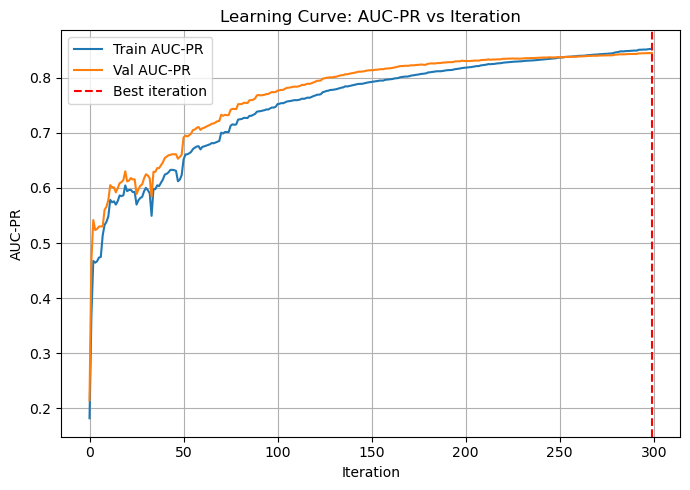


Model and transformer saved.


In [11]:
# ----- Create model folder -----
os.makedirs("../model", exist_ok=True)

# ----- Calculate class imbalance weight -----
num_neg = np.sum(y_train == 0)
num_pos = np.sum(y_train == 1)
scale_pos_weight = num_neg / num_pos
print(f"Using scale_pos_weight = {scale_pos_weight:.2f}")

# ----- Define model -----
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_estimators=300,
    reg_lambda=1.0,
    reg_alpha=0.5,
    random_state=42,
    n_jobs=-1
)

# ----- Train -----
print("Training model...")
model.fit(
    X_train_trans, y_train,
    eval_set=[
        (X_train_trans, y_train),
        (X_val_trans, y_val)
    ],
    verbose=True
)

# ----- Track best iteration manually -----
results = model.evals_result()
val_aucpr = results['validation_1']['aucpr']
best_iter = int(np.argmax(val_aucpr))
best_aucpr = float(np.max(val_aucpr))

print(f"\nBest iteration (manual): {best_iter}")
print(f"Best AUC-PR (val): {best_aucpr:.4f}")

# ----- Plot Learning Curve (Train vs Val AUC-PR) -----
plt.figure(figsize=(7, 5))
plt.plot(results['validation_0']['aucpr'], label='Train AUC-PR')
plt.plot(results['validation_1']['aucpr'], label='Val AUC-PR')
plt.axvline(best_iter, color='r', linestyle='--', label='Best iteration')
plt.xlabel('Iteration')
plt.ylabel('AUC-PR')
plt.title('Learning Curve: AUC-PR vs Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----- Save model and transformer -----
joblib.dump(model, "../model/xgb_model.pkl")
joblib.dump(col_transformer, "../model/col_transformer.pkl")
print("\nModel and transformer saved.")


=== TRAIN SET EVALUATION ===

Confusion Matrix:
[[5015591   70546]
 [      1    3958]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9861    0.9930   5086137
           1     0.0531    0.9997    0.1009      3959

    accuracy                         0.9861   5090096
   macro avg     0.5266    0.9929    0.5470   5090096
weighted avg     0.9993    0.9861    0.9923   5090096


ROC AUC (Train): 0.9997
PR AUC  (Train): 0.8530

=== TEST SET EVALUATION ===

Confusion Matrix:
[[623552   8946]
 [    21   3743]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9859    0.9929    632498
           1     0.2950    0.9944    0.4550      3764

    accuracy                         0.9859    636262
   macro avg     0.6475    0.9901    0.7239    636262
weighted avg     0.9958    0.9859    0.9897    636262


ROC AUC Score: 0.9994
PR AUC Score: 0.9390


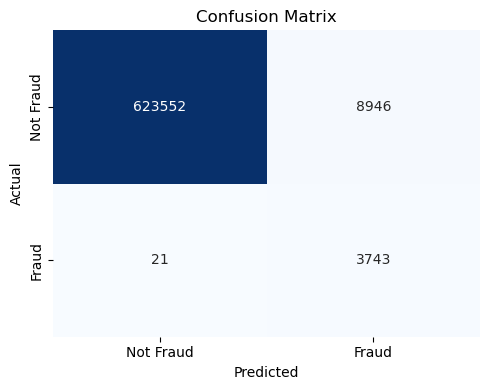

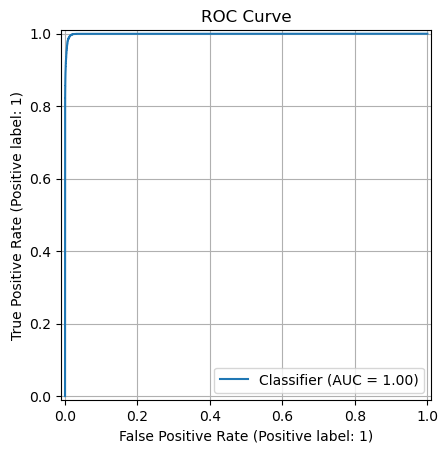

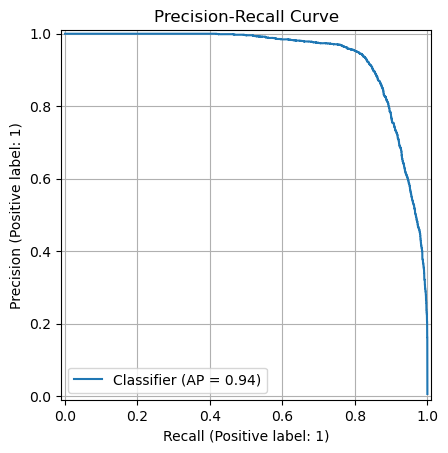

In [15]:
# Load model and transformer
model = joblib.load("../model/xgb_model.pkl")
col_transformer = joblib.load("../model/col_transformer.pkl")

# Transform test + train
X_test_trans = col_transformer.transform(X_test)
X_train_trans = col_transformer.transform(X_train)

# ========== TRAIN EVALUATION ==========
print("=== TRAIN SET EVALUATION ===")
y_train_pred = model.predict(X_train_trans)
y_train_proba = model.predict_proba(X_train_trans)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, digits=4))

roc_auc_train = roc_auc_score(y_train, y_train_proba)
pr_auc_train = average_precision_score(y_train, y_train_proba)

print(f"\nROC AUC (Train): {roc_auc_train:.4f}")
print(f"PR AUC  (Train): {pr_auc_train:.4f}")

# ========== TEST EVALUATION ==========
print("\n=== TEST SET EVALUATION ===")
y_pred = model.predict(X_test_trans)
y_proba = model.predict_proba(X_test_trans)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ----- AUC Scores -----
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"\nROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# ----- Confusion Matrix (Plot) -----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ----- ROC Curve -----
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# ----- Precision-Recall Curve -----
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


# Summary

### 1. แนวทางการพัฒนาโมเดล
- ในการพัฒนาโมเดลตรวจจับธุรกรรมฉ้อโกง (Fraud Detection) ครั้งนี้ มีเป้าหมายหลักเพื่อให้โมเดลสามารถตรวจจับธุรกรรมที่มีความเสี่ยงได้มากที่สุด (High Recall) โดยยอมให้มีความผิดพลาดในรูปแบบ False Positive บ้าง เนื่องจากในบริบทของการฉ้อโกงทางการเงิน ความเสียหายจากการพลาดการตรวจจับ (False Negative) มีค่ามากกว่าความเสียหายจากการเตือนเกิน (False Positive) ดังนั้นการออกแบบโมเดลจึงเน้นให้มี Recall สูงสุด ภายใต้การควบคุม Precision ให้อยู่ในระดับที่ยอมรับได้ในทางปฏิบัติ
- โมเดลที่เลือกใช้คือ XGBoost (Extreme Gradient Boosting) ซึ่งมีความสามารถในการจัดการข้อมูลที่มีความไม่สมดุลระหว่างคลาส (class imbalance) ได้ดี โดยได้กำหนดพารามิเตอร์ scale_pos_weight ตามสัดส่วนระหว่างข้อมูลปกติและข้อมูลฉ้อโกง เพื่อเพิ่มน้ำหนักให้กับคลาสที่มีจำนวนน้อยกว่า

### 2. ประสิทธิภาพโดยรวมของโมเดล

หลังจากทำการฝึกและประเมินโมเดลด้วยชุดข้อมูลฝึก (Train set) และชุดข้อมูลทดสอบ (Test set) พบว่าโมเดลมี ความแม่นยำ (Accuracy) สูงถึง 98.59% บนชุดทดสอบ ซึ่งถือว่าอยู่ในระดับที่ดีมาก อย่างไรก็ตาม เนื่องจากปัญหานี้มีลักษณะของข้อมูลที่ไม่สมดุล (ธุรกรรมปกติมีจำนวนมากกว่าธุรกรรมฉ้อโกงหลายเท่า) ค่า Accuracy เพียงอย่างเดียวไม่สามารถสะท้อนประสิทธิภาพของโมเดลได้อย่างแท้จริง จำเป็นต้องพิจารณา metric อื่น ๆ ร่วมด้วย ได้แก่ Precision, Recall, F1-score, และ AUC-PR

### 3. การวิเคราะห์ Precision, Recall และ F1-score

| Metric              | Train Set | Test Set |
| ------------------- | --------- | -------- |
| Precision (class 1) | 5.30%     | 29.51%   |
| Recall (class 1)    | 99.97%    | 99.44%   |
| F1-score (class 1)  | 10.09%    | 45.54%   |

ผลการประเมินแสดงให้เห็นว่า:

* **Recall (class 1) = 99.44%** แสดงว่าโมเดลสามารถตรวจจับธุรกรรมที่เป็นการฉ้อโกงได้เกือบทั้งหมด โดยมี **False Negative เพียง 21 รายการ จากทั้งหมด 3,764 รายการ** ซึ่งถือว่าต่ำมาก
* **Precision (class 1) = 29.51%** หมายความว่าในบรรดาธุรกรรมที่โมเดลทำนายว่าเป็นการฉ้อโกง มีประมาณ 30% ที่เป็นจริง ซึ่งเป็นผลจากลักษณะข้อมูลที่มี class imbalance สูง
* **F1-score = 45.54%** เป็นค่าที่สะท้อนถึงสมดุลระหว่าง Precision และ Recall โดยค่าดังกล่าวถือว่าเหมาะสมกับโจทย์ที่เน้นการจับธุรกรรมฉ้อโกงให้ได้ครบมากกว่าการลดจำนวน False Positive

โดยสรุป โมเดลนี้ถูกออกแบบให้ยอมเตือนเกิน เพื่อป้องกันการพลาดการตรวจจับธุรกรรมฉ้อโกง ซึ่งสอดคล้องกับแนวทางของระบบตรวจสอบทางการเงินที่มักให้ความสำคัญกับ Recall มากกว่า Precision

### 4. การวิเคราะห์ด้วย AUC-ROC และ AUC-PR

| Metric  | Train Set | Test Set |
| ------- | --------- | -------- |
| ROC AUC | 0.9997    | 0.9994   |
| PR AUC  | 0.8530    | 0.9390   |

* ค่า **ROC AUC ≈ 1.0** บ่งชี้ว่าโมเดลสามารถแยกแยะธุรกรรมปกติและธุรกรรมฉ้อโกงได้อย่างมีประสิทธิภาพสูงมาก
* ค่า **PR AUC = 0.9390** บนชุดทดสอบ แสดงให้เห็นว่าโมเดลสามารถจัดลำดับธุรกรรมที่มีความเสี่ยงได้ดีเยี่ยม โดยเฉพาะในบริบทที่ข้อมูลไม่สมดุล

ค่า PR AUC ที่สูงนี้สะท้อนความสามารถของโมเดลในการนำไปใช้ในระบบการจัดลำดับความเสี่ยง เช่น การแสดงรายการธุรกรรมที่มีโอกาสเป็นการฉ้อโกงสูงสุด 100 รายการ เพื่อให้เจ้าหน้าที่ตรวจสอบต่อในขั้นตอนถัดไป

### 5. การวิเคราะห์ Confusion Matrix

|                          | ทำนายว่าไม่ Fraud | ทำนายว่า Fraud |
| ------------------------ | ----------------: | -------------: |
| **จริง: ไม่ Fraud (TN)** |           623,552 |          8,946 |
| **จริง: Fraud (FN)**     |                21 |          3,743 |

* **False Negative (FN) = 21** → ต่ำมาก แสดงว่าโมเดลแทบไม่พลาดธุรกรรมฉ้อโกงจริง
* **False Positive (FP) = 8,946** → ค่อนข้างมากในเชิงปริมาณ แต่ถือว่ายอมรับได้ เนื่องจากธุรกรรมเหล่านี้สามารถผ่านกระบวนการตรวจสอบโดยเจ้าหน้าที่ภายหลังได้

หากจำนวน False Positive สูงจนสร้างภาระต่อระบบหรือทีมตรวจสอบ อาจปรับ threshold การตัดสินใจ หรือเพิ่มกระบวนการ post-processing เช่น การใช้ rule-based filtering ร่วมกับโมเดลเพื่อจำกัดปริมาณธุรกรรมที่ต้องตรวจสอบจริง

### 6. ความพร้อมต่อการนำไปใช้งานจริง

โมเดล XGBoost ที่พัฒนาในงานวิจัยนี้สามารถนำไปประยุกต์ใช้ในระบบ **ตรวจสอบธุรกรรมแบบ Real-Time** ได้อย่างเหมาะสม โดยมีคุณสมบัติสำคัญดังนี้:

* **High Recall**: ช่วยลดความเสี่ยงจากการพลาดธุรกรรมฉ้อโกงที่แท้จริง
* **High PR AUC**: ช่วยจัดลำดับความเสี่ยงได้แม่นยำ เพื่อเพิ่มประสิทธิภาพการทำงานของเจ้าหน้าที่
* **ความเร็วในการประมวลผลสูง**: XGBoost ใช้เวลาในการทำนายระดับมิลลิวินาที เหมาะกับระบบที่ต้องการตอบสนองแบบทันที
* **สามารถกำหนด threshold ตามระดับความเสี่ยงได้อย่างยืดหยุ่น** เช่น

  * `proba > 0.90` → บล็อกธุรกรรมโดยอัตโนมัติ
  * `0.60 < proba ≤ 0.90` → ส่งต่อให้เจ้าหน้าที่ตรวจสอบ
  * `proba ≤ 0.60` → ผ่านระบบปกติ

### 7. ข้อเสนอแนะสำหรับการพัฒนาโมเดลเพิ่มเติม
- การลดจำนวนตัวอย่างของ class 0 (Under-sampling): เพื่อปรับสมดุลของข้อมูล และอาจช่วยให้ Precision ดีขึ้น โดยไม่กระทบ Recall มากนัก
- การใช้ cost-sensitive learning: ปรับ weight ของ class หรือใช้ loss function ที่ penalize False Positive ให้แรงขึ้น
- การเพิ่ม feature ที่ช่วยแยกฉ้อโกงได้ดีขึ้น: เช่น ความถี่ของบัญชี, เวลาที่ทำรายการ, ความสัมพันธ์ของบัญชีต้นทาง–ปลายทาง เป็นต้น
- การใช้ ensemble หลายโมเดล: เพื่อรวมข้อดีของโมเดลที่แม่นยำแต่ Recall ต่ำ กับโมเดลที่ Recall สูงแต่ Precision ต่ำ
- การวิเคราะห์ธุรกรรมเชิงเวลา (time-series features): อาจช่วยให้โมเดลเข้าใจพฤติกรรมสะสมที่นำไปสู่การฉ้อโกงได้ดีขึ้น

### 8. สรุปภาพรวม

โดยสรุป โมเดล XGBoost ที่พัฒนาขึ้นนี้สามารถตรวจจับธุรกรรมฉ้อโกงได้อย่างมีประสิทธิภาพสูง ด้วย Recall ที่เกือบสมบูรณ์และ AUC-PR ที่โดดเด่น เหมาะสมกับการนำไปใช้งานในระบบตรวจสอบธุรกรรมแบบอัตโนมัติ โดยเฉพาะในขั้นตอนการคัดกรองเบื้องต้น (Fraud Pre-screening System) ซึ่งสามารถช่วยลดความเสี่ยงทางการเงินได้อย่างมีนัยสำคัญ ทั้งนี้ การนำไปใช้จริงควรมีกระบวนการควบคุม False Positive ผ่าน threshold tuning และการตรวจสอบร่วมกับมนุษย์ เพื่อให้ได้ผลลัพธ์ที่เหมาะสมทั้งในเชิงเทคนิคและธุรกิจ
